In [62]:
# import library
import os
import sys
sys.path.append(os.pardir) 
import nltk, re
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding, Dense, Input, Bidirectional, LSTM, Dropout, CuDNNLSTM
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

import konlpy
from konlpy.tag import Komoran
from konlpy.tag import Twitter
from konlpy.tag import Hannanum
from gensim.models import FastText

import pickle
import codecs
import csv
import struct

In [63]:
TEXT_DATA_DIR = './newsData'
directory_label = {0: '정치', 1: '경제', 2: '사회', 3 : '생활/문화', 4 : '세계', 5 : '기술/IT', 6 : '연예', 7 : '스포츠'}

In [64]:
#WORD_EMBEDDING_WORD2VEC = './wiki.ko/wiki.ko.bin'
#WORD_EMBEDDING_WORD2VEC = './wiki.ko/wiki.ko.vec'

In [65]:
# parameter
EMBEDDING_DIM = 100
#EMBEDDING_DIM = 200
#EMBEDDING_DIM = 300

In [66]:
TEST_SPLIT = 0.15
VALIDATION_SPLIT = 0.15

In [67]:
# konlp Objects
komo = Komoran()
twitter = Twitter()
hannanum = Hannanum()

In [68]:
# list of texts
Texts = []  
trainTexts = []
validationTexts = []
testTexts = [] 

In [69]:
# list of label ids
Labels = []
trainLabels = []  
validationLabels = []
testLabels = []

In [70]:
# dictionary mapping label name to numeric id
labels_index = {}

In [71]:
# sequence of texts
seq = []

In [72]:
print(Texts)

[]


In [73]:
# load texts data
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[directory_label[int(name)]] = label_id
        for fname in sorted(os.listdir(path)):
            fpath = os.path.join(path, fname)
            args = {'encoding': 'utf-8'}
            if(re.findall('.1[6789][0-9]NewsData',fpath)):
                # test texts
                text = []
                with open(fpath, **args) as f:
                    t = f.read()
                    #pos = twitter.pos(t.strip())
                    #pos = hannanum.pos(t.strip())
                    pos = komo.pos(t.strip())
                    for pair in pos :
                        #['NNG', 'NNP', 'VV', 'VA']: part-of-speech of content word
                        if (re.findall('NNP|NNG',pair[1])):
                            if(len(pair[0]) > 1):
                                morpheme = pair[0]
                                text.append(morpheme)
                    testTexts.append(text)
                testLabels.append(label_id)
            else :
                # train & validation texts
                text = []
                with open(fpath, **args) as f:
                    t = f.read()
                    #pos = twitter.pos(t.strip())
                    #pos = hannanum.pos(t.strip())
                    pos = komo.pos(t.strip())
                    for pair in pos :
                        if (re.findall('NNP|NNG',pair[1])):
                              if(len(pair[0]) > 1):
                                morpheme = pair[0]
                                text.append(morpheme)
                    Texts.append(text)
                Labels.append(label_id)
            seq.append(text)
print('Found %s texts.' % len(Texts))
print('Found %s texts.' % len(testTexts))
print(len(Labels))
print(len(testLabels))

Found 1280 texts.
Found 320 texts.
1280
320


In [74]:
print(Texts[2])
print(Labels[2])

['외압', '논란', '항명', '사태', '권성동', '영장', '청구', '미현', '검사', '외압', '폭로', '파문', '별도', '수사단', '구성', '영장', '검찰총장', '개입', '논란', '내홍', '구속', '여부', '결정', '시일', '미현', '검사', '권성동', '의원', '문무', '검찰총장', '왼쪽', '미현', '검사', '권성동', '자유', '한국당', '의원', '문무', '검찰총장', '연합뉴스', '서울', '연합뉴스', '김지헌', '기자', '검찰', '논란', '권성동', '자유', '한국당', '의원', '구속영장', '청구', '의원', '신병', '처리', '주목', '강원랜드', '채용', '비리', '관련', '수사단', '단장', '양부', '광주지검', '업무방해', '뇌물수수', '직권', '남용', '권리', '행사', '방해', '혐의', '의원', '구속영장', '청구', '현직', '검사', '강원랜드', '채용', '비리', '수사', '외압', '언론', '폭로', '춘천지검', '강원랜드', '채용', '비리', '관련', '최흥집', '강원랜드', '사장', '사건', '수사', '미현', '사법연수원', '의정부지검', '검사', '최종원', '춘천지검', '서울남부지검', '사건', '수사', '조기', '종결', '지시', '2월 4일', '주장', '검사', '수사', '진행', '지난해', '국회 법제사법위원회', '권성동', '의원', '고검장', '사장', '측근', '사이', '연락', '수사', '개입', '의심', '정황', '주장', '검사', '상관', '수사', '대상', '의원', '불편', '의원', '염동열', '의원', '고검장', '이름', '등장', '증거', '목록', '삭제', '압력', '지속', '폭로', '양부', '강원랜드', '채용', '비리', '수사단장', '연합뉴스', '자료', '사진', '국회의원', '검찰', '유착'

In [75]:
#MAX_FEATURES = 10000
MAX_FEATURES = 20000
#MAX_FEATURES = 30000

In [76]:
#Word2Vec
model_ko = FastText(seq, min_count=3, size=EMBEDDING_DIM, window=5) 
words = list(model_ko.wv.vocab)
embeddings_index = {}
for i in words:
    embeddings_index[i] = model_ko[i]

C:\Users\MinhoLee\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [77]:
embeddings_index

{'동남아': array([-0.10836137, -0.00839009,  0.01862224,  0.09962993,  0.07614619,
         0.11744351,  0.01475462, -0.0215411 , -0.01652769,  0.09736323,
         0.01561987,  0.01025317, -0.10278339, -0.03252345,  0.0476019 ,
        -0.01156228, -0.00500819, -0.05347472, -0.01875914, -0.04220306,
         0.056081  , -0.00885834,  0.10667945, -0.00469542,  0.02967668,
        -0.07235539, -0.01520836, -0.01040133,  0.03617865,  0.016205  ,
         0.02742195, -0.13326003,  0.02124006, -0.03720095,  0.15038349,
         0.10498462,  0.08072785, -0.06391563, -0.10818119, -0.050983  ,
         0.00705595, -0.00653105, -0.06359948,  0.01552389, -0.00249911,
         0.06056244, -0.11279128,  0.076023  ,  0.02991322, -0.02303435,
        -0.0388191 ,  0.11455219, -0.00201607, -0.00551955, -0.00429447,
         0.01403237,  0.02380717,  0.01832244, -0.01156554,  0.06425875,
        -0.01704304,  0.12159308, -0.04571968, -0.04068512, -0.03659428,
         0.02259807, -0.02521104, -0.0836742

In [78]:
print(len(Texts))

1280


In [79]:
# by default, validation_split in `fit` does not shuffle the data
indices = np.arange(len(Texts), dtype=int)
print(type(indices[0]))

<class 'numpy.int32'>


In [80]:
indices = np.arange(len(Texts))
print(indices)
np.random.shuffle(indices)

Texts = np.array(Texts)
Labels = np.array(Labels)

Texts = Texts[indices]
Labels = Labels[indices]

indices2 = np.arange(len(testTexts))
np.random.shuffle(indices2)

testTexts = np.array(testTexts)
testLabels = np.array(testLabels)

testTexts = testTexts[indices2]
testLabels = testLabels[indices2]

[   0    1    2 ... 1277 1278 1279]


In [81]:
num_validation_samples = int(VALIDATION_SPLIT * len(Texts))

validationTexts = Texts[:num_validation_samples]
validationLabels = Labels[:num_validation_samples]

trainTexts = Texts[num_validation_samples:]
trainLabels = Labels[num_validation_samples:]

In [82]:
print(len(trainTexts))
print(len(validationTexts))
print(len(testTexts))

1088
192
320


In [83]:
# train & validation texts의 길이 분포 list
trainLen  = list()
for i in range(len(trainTexts)):
    trainLen.append(len(trainTexts[i]))

In [84]:
# train & validation texts의 길이 분포 list
validationLen  = list()
for i in range(len(validationTexts)):
    validationLen.append(len(validationTexts[i]))

In [85]:
# test texts의 길이 분포 list
testLen  = list()
for i in range(len(testTexts)):
    testLen.append(len(testTexts[i]))

C:\Users\MinhoLee\Anaconda3\envs\venv\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\MinhoLee\Anaconda3\envs\venv\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\MinhoLee\Anaconda3\envs\venv\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


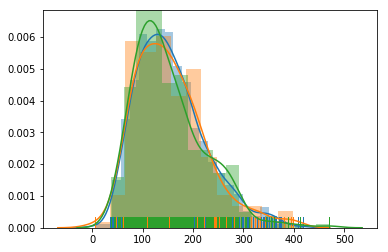

In [86]:
# 각 text별로 길이 분포
import seaborn as sns
sns.distplot(trainLen, hist = True, rug =True);
sns.distplot(validationLen, hist = True, rug =True);
sns.distplot(testLen, hist= True, rug =True)
plt.show()

In [87]:
#MAX_SEQUENCE_LENGTH = 150
#MAX_SEQUENCE_LENGTH = 200
#MAX_SEQUENCE_LENGTH = 250
MAX_SEQUENCE_LENGTH = 150
#MAX_SEQUENCE_LENGTH = 350

In [88]:
# tokenizer 선언
tokenizer = Tokenizer(num_words=MAX_FEATURES)

TEXT = list()
for i in range(len(trainTexts)):
    TEXT.append(trainTexts[i])
    
for i in range(len(validationTexts)):
    TEXT.append(validationTexts[i]) 
    
for i in range(len(testTexts)):
    TEXT.append(testTexts[i])  

In [89]:
# train on `texts token' (list of sample texts)`
# return list of sequences (one per text)

tokenizer.fit_on_texts(TEXT)
sequences = tokenizer.texts_to_sequences(TEXT)
sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print(len(sequences))
# sequence는 전체?

1600


In [90]:
type(trainLabels)

numpy.ndarray

In [91]:
x_train = sequences[:1088]
y_train = to_categorical(trainLabels)

x_val = sequences[1088:1280]
y_val = to_categorical(validationLabels)

x_test = sequences[1280:]
y_test = to_categorical(testLabels)

In [92]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1088, 8)
(192, 8)
(320, 8)


In [93]:
print(trainTexts[0])
print(x_train[0])
print(y_train[0])

['작품', '준비', '피겨', '최다', '모습', '스포츠', '목동', '보미', '기자', '모습', '피겨스케이팅', '최다', '고려대', '아이스쇼', '기대감', '최다', '목동아이스링크', 'SK텔레콤', '스케이트', '아이스쇼', '참여', '이번', '공연', '최다', '작품', '준비', '대부', '갈라', '예정', '공연', '물랑루즈', '최다', '경기', '아이스쇼', '퍼포먼스', '프로그램', '색깔', '모습', '이번', '아이스쇼', '갈라', '김연아', '특별 출연', '최다', '우상', '언니', '전설', '영광', '시간', '최다', '2018 평창동계올림픽', '최종', '차지', '포스트', '김연아', '아이스쇼', '무대', '최다', '우상', '김연아', '공연', '표정']
[  631   155  1689  1889    53   446  5265 13751     1    53  4769  1889
  5266  1192   988  1889  4770  1589  3339  1192   203     5   678  1889
   631   155  1890  8643    37   678  8644  1889    46  1192  4385   196
  4060    53     5  1192  8643   772 10451  1889  8645  2278  5818  3776
     4  1889  4061   327   362  4771   772  1192   507  1889  8645   772
   678  1260     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0

In [94]:
# Map: word -> rank/index(int) in text
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(word_index)

Found 21530 unique tokens.
{'기자': 1, '서울': 2, '북한': 3, '시간': 4, '이번': 5, '미국': 6, '대통령': 7, '관련': 8, '사람': 9, '이날': 10, '경찰': 11, '조사': 12, '이후': 13, '한국': 14, '중국': 15, '경우': 16, '대표': 17, '문제': 18, '지난해': 19, '사실': 20, '후보': 21, '관계자': 22, '정부': 23, '의원': 24, '혐의': 25, '대회': 26, '상황': 27, '최근': 28, '진행': 29, '시장': 30, '결과': 31, '이상': 32, '자신': 33, '수사': 34, '지역': 35, '주장': 36, '예정': 37, '확인': 38, '연구': 39, '시작': 40, '설명': 41, '사건': 42, '오후': 43, '가격': 44, '공개': 45, '경기': 46, '입장': 47, '생각': 48, '국내': 49, '정도': 50, '회담': 51, '당시': 52, '모습': 53, '연합뉴스': 54, '방송': 55, '필요': 56, '회장': 57, '사용': 58, '올해': 59, '세계': 60, '발표': 61, '트럼프': 62, '위원장': 63, '일본': 64, '이유': 65, '발생': 66, '정상회담': 67, '여성': 68, '사고': 69, '계획': 70, '루킹': 71, '과정': 72, '일부': 73, '검찰': 74, '선수': 75, '내용': 76, '상태': 77, '처리': 78, '이용': 79, '한국당': 80, '국회': 81, '기록': 82, '사업': 83, '오전': 84, '현지': 85, '수준': 86, '예상': 87, '서비스': 88, '한편': 89, '논란': 90, '정상': 91, '증가': 92, '기준': 93, '분석': 94, '지적': 95, '지원': 96, '규모': 97, 

In [95]:
num_words = min(MAX_FEATURES, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_FEATURES:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [96]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [97]:
# path where all models are saved
BASE_PATH = './newsModel/'
if not os.path.exists(BASE_PATH):
    os.mkdir(BASE_PATH)

In [98]:
def create_checkpoint(model_name):
    # creates a subdirectory under `BASE_PATH`
    MODEL_PATH = os.path.join(BASE_PATH, model_name)
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    
    return ModelCheckpoint(filepath=os.path.join(MODEL_PATH, '{epoch:02d}-{val_loss:.4f}.hdf5'),
                           monitor='val_loss',
                           verbose=1,
                           save_best_only=True)

In [99]:
batch_size = 64
max_epochs = 200
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3)

In [100]:
print('Training...')

# train a 3-layer bi-LSTM model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

Training...


In [101]:
print('Training...')

# train a 3-layer bi-LSTM model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

Training...


In [102]:
sequence_input

<tf.Tensor 'input_5:0' shape=(?, 150) dtype=int32>

In [104]:
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(embedded_sequences)
x = Dropout(0.5)(x)
x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = Bidirectional(CuDNNLSTM(32))(x)
x = Dropout(0.5)(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

checkpoint = create_checkpoint('lstm')  # checkpoint callback
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=max_epochs,
          validation_data=(x_val, y_val),
          shuffle=True,
          callbacks= [checkpoint])

Train on 1088 samples, validate on 192 samples
Epoch 1/200
1088/1088 [==============================] - 3s 3ms/step - loss: 2.0658 - acc: 0.1507 - val_loss: 1.9897 - val_acc: 0.2135

Epoch 00001: val_loss improved from inf to 1.98972, saving model to ./newsModel/lstm\01-1.9897.hdf5
Epoch 2/200
1088/1088 [==============================] - 1s 1ms/step - loss: 1.9938 - acc: 0.1958 - val_loss: 1.9381 - val_acc: 0.2292

Epoch 00002: val_loss improved from 1.98972 to 1.93810, saving model to ./newsModel/lstm\02-1.9381.hdf5
Epoch 3/200
1088/1088 [==============================] - 1s 1ms/step - loss: 1.9313 - acc: 0.2371 - val_loss: 1.8102 - val_acc: 0.3229

Epoch 00003: val_loss improved from 1.93810 to 1.81024, saving model to ./newsModel/lstm\03-1.8102.hdf5
Epoch 4/200
1088/1088 [==============================] - 1s 1ms/step - loss: 1.8482 - acc: 0.2895 - val_loss: 1.7247 - val_acc: 0.3854

Epoch 00004: val_loss improved from 1.81024 to 1.72474, saving model to ./newsModel/lstm\04-1.7247.hd

1088/1088 [==============================] - 1s 1ms/step - loss: 1.1373 - acc: 0.5855 - val_loss: 1.1475 - val_acc: 0.5312

Epoch 00039: val_loss did not improve from 1.10504
Epoch 40/200
1088/1088 [==============================] - 1s 1ms/step - loss: 1.1257 - acc: 0.5901 - val_loss: 1.1475 - val_acc: 0.5521

Epoch 00040: val_loss did not improve from 1.10504
Epoch 41/200
1088/1088 [==============================] - 1s 1ms/step - loss: 1.1533 - acc: 0.5965 - val_loss: 1.1937 - val_acc: 0.5625

Epoch 00041: val_loss did not improve from 1.10504
Epoch 42/200
1088/1088 [==============================] - 1s 1ms/step - loss: 1.2203 - acc: 0.5506 - val_loss: 1.1725 - val_acc: 0.5052

Epoch 00042: val_loss did not improve from 1.10504
Epoch 43/200
1088/1088 [==============================] - 1s 1ms/step - loss: 1.1686 - acc: 0.5680 - val_loss: 1.1416 - val_acc: 0.5885

Epoch 00043: val_loss did not improve from 1.10504
Epoch 44/200
1088/1088 [==============================] - 1s 1ms/step - l

1088/1088 [==============================] - 1s 1ms/step - loss: 0.7476 - acc: 0.7362 - val_loss: 1.2192 - val_acc: 0.5469

Epoch 00082: val_loss did not improve from 1.08014
Epoch 83/200
1088/1088 [==============================] - 1s 1ms/step - loss: 0.7924 - acc: 0.7381 - val_loss: 1.1497 - val_acc: 0.5833

Epoch 00083: val_loss did not improve from 1.08014
Epoch 84/200
1088/1088 [==============================] - 1s 1ms/step - loss: 0.7641 - acc: 0.7270 - val_loss: 1.1100 - val_acc: 0.6094

Epoch 00084: val_loss did not improve from 1.08014
Epoch 85/200
1088/1088 [==============================] - 1s 1ms/step - loss: 0.7225 - acc: 0.7546 - val_loss: 1.2257 - val_acc: 0.5833

Epoch 00085: val_loss did not improve from 1.08014
Epoch 86/200
1088/1088 [==============================] - 1s 1ms/step - loss: 0.7479 - acc: 0.7491 - val_loss: 1.1105 - val_acc: 0.6198

Epoch 00086: val_loss did not improve from 1.08014
Epoch 87/200
1088/1088 [==============================] - 1s 1ms/step - l


Epoch 00125: val_loss did not improve from 1.08014
Epoch 126/200
1088/1088 [==============================] - 1s 1ms/step - loss: 0.4089 - acc: 0.8732 - val_loss: 1.4124 - val_acc: 0.5938

Epoch 00126: val_loss did not improve from 1.08014
Epoch 127/200
1088/1088 [==============================] - 1s 1ms/step - loss: 0.3692 - acc: 0.8842 - val_loss: 1.4079 - val_acc: 0.6146

Epoch 00127: val_loss did not improve from 1.08014
Epoch 128/200
1088/1088 [==============================] - 1s 1ms/step - loss: 0.3642 - acc: 0.8704 - val_loss: 1.4040 - val_acc: 0.5625

Epoch 00128: val_loss did not improve from 1.08014
Epoch 129/200
1088/1088 [==============================] - 1s 1ms/step - loss: 0.3854 - acc: 0.8778 - val_loss: 1.5776 - val_acc: 0.5781

Epoch 00129: val_loss did not improve from 1.08014
Epoch 130/200
1088/1088 [==============================] - 1s 1ms/step - loss: 0.3839 - acc: 0.8824 - val_loss: 1.4704 - val_acc: 0.5833

Epoch 00130: val_loss did not improve from 1.08014
Epo

1088/1088 [==============================] - 1s 1ms/step - loss: 0.2307 - acc: 0.9210 - val_loss: 1.8417 - val_acc: 0.5573

Epoch 00169: val_loss did not improve from 1.08014
Epoch 170/200
1088/1088 [==============================] - 1s 1ms/step - loss: 0.1963 - acc: 0.9439 - val_loss: 2.0272 - val_acc: 0.5365

Epoch 00170: val_loss did not improve from 1.08014
Epoch 171/200
1088/1088 [==============================] - 1s 1ms/step - loss: 0.1787 - acc: 0.9439 - val_loss: 1.9000 - val_acc: 0.5729

Epoch 00171: val_loss did not improve from 1.08014
Epoch 172/200
1088/1088 [==============================] - 1s 1ms/step - loss: 0.2189 - acc: 0.9384 - val_loss: 1.9028 - val_acc: 0.5781

Epoch 00172: val_loss did not improve from 1.08014
Epoch 173/200
1088/1088 [==============================] - 1s 1ms/step - loss: 0.1754 - acc: 0.9494 - val_loss: 1.9817 - val_acc: 0.5417

Epoch 00173: val_loss did not improve from 1.08014
Epoch 174/200
1088/1088 [==============================] - 1s 1ms/ste

In [ ]:
# Visualize training (optional)
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(8,8))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 3.0])

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
loss, acc = model.evaluate(x_test, y_test,
                           batch_size=batch_size)

print(f'----- Evaluation loss and metrics for {len(y_test)} test samples -----')
print('Test loss:', loss)
print('Test accuracy:', acc)